# Training Neural Networks

* 이전 시간까지 만들었던 neural network은 똑똑하지는 않았죠 (training을 하지 않아 손글씨를 분류하지 못했습니다)
* 궁극적으로 neural network은 다양한 function으로 fitting 될 수 있는 universal function approximator가 될 수 있습니다

* 즉 training을 잘 거친 neural network은 손글씨 image를 분류하는 분류 function으로 변신이 가능한 것이죠
* 더욱이, 낮은 복잡도 내에서 수행 가능합니다
<img src="assets/function_approx.png" width=500px>

* 수업에서 배운 것과 같이, 좋은 parameter를 찾는 과정을 위해서 *성능*을 측정할 수 있는 측도, 즉 **loss function**이 필요합니다
* 예를 들어서 mean squared loss 는 regression 문제와 binary classification 문제에 적용 가능합니다 (classification을 위해서는 더 좋은 loss function이 존재합니다)

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

* 위 수식에서 $n$은 training sample의 수, $y_i$는 true labels, $\hat{y}_i$은 예측입니다

* 위 loss function을 network parmeter에 대해서 최소화하는 것이 *학습* 이죠
* 최소 값을 찾는 과정은 **gradient descent**를 사용합니다
* Gradient descent는 loss function의 기울기를 정보를 활용하여 최소값을 찾아가는 과정이죠 (이론강의 참고)

<img src='assets/gradient_descent.png' width=350px>

## Loss Functions in PyTorch

* 다음 과정으로, Pytorch에서 loss를 어떻게 연산하는지 배워보죠
* `nn` module에서 다양한 loss function을 제공하는데, 예를 들면 `nn.CrossEntropyLoss`와 같은 함수가 있습니다
    * 보통 관습적으로 loss function은 `critertion`이라는 변수로 받습니다 (`loss_function`등도 당연히 사용 가능합니다)
* 지난 시간에 MNIST 문제는 확률 분포를 output으로 받는 것이 필요하다고 (또는 자연스러운 선택 임을) 학습했습니다 
* 이런 확률 분포를 output으로 받는 경우 대응되는 좋은 loss function이 cross entropy입니다 (이론 강의에서 cross entropy가 무엇을 의미하는지 설명한 부분을 복습 해보세요)

* Cross entropy의 정의는 
\begin{align*}
 H(P, Q) &= -\mathbb{E}_{y\sim P} \log(Q(y)) \\
 &=-\sum_{y\in\mathcal{Y}} P(y)\log(Q(y))
\end{align*}
* 위 식은 두 확률 분포의 "거리"를 표현하는 식이라고 배웠습니다
* 위에서 $P(x)$는 $x$의 label을 one hot coding 한 vector이고 $Q(x)$는 softmax를 취한 network output입니다
* One hot coding은 y label이 1이면 첫번째 자리만 '1'이고 나머지는 영인 벡터, y label이 $k$이면 $k$ 번째 자리만 '1'이고 나머지는 0인 벡터입니다

* 예를들어서 y=2에 대한 one hot encoding
\begin{align*}
y_\textrm{one_hot}(2) &= \begin{array}{cccccc}
[0 & 1 & 0 & \cdots & 0]
\end{array}
\end{align*}

* 위 cross entropy 식에 대응 하는 방식은:
\begin{align*}
P(y=2) = y_\textrm{one_hot}(2)
\end{align*}

* 또한, neural network의 마지막 linear layer의 output 값이 $z$라고 할때,
\begin{align*}
Q(y=2) = \sigma(z_2) = \cfrac{\exp(z_2)}{\sum_k^K{\exp(z_k)}}
\end{align*}

<img src='assets/NLLLoss.jpg' width=550px>

* pytorch에서 이를 수행하기 위해서 criterion을 `nn.CrossEntropyLoss`로 생성하고, network의 예측 값과, 실제 label 값을 입력으로 loss를 계산합니다
  * 본 과정은 차근차근 설명하겠습니다
* 그 전에 Pytorch에서 cross entropy 함수를 어떻게 적용하는지 먼저 이해할 필요가 있습니다 (중요합니다!!!)
  * [Pytorch.org `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)를 살펴보면

> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
>
> The input is expected to contain scores for each class.

* `nn.CrossEntropyLoss`는 `nn.LogSoftmax()`와 `nn.NLLLoss()` 하나의 class에서 수행한다고 되어 있습니다. 
* 두번째 줄에서 NLLLoss 는 negative log likelihood loss 입니다 

* 이게 의미하는 바가 무엇이냐면, network의 output을 softmax function을 적용하여 출력하지 말고, softmax는 loss function에서 계산한다는 뜻입니다
* 이렇게 구현한 이유는, 확률값이 작을 수 있어서 computation precision error를 방지하기 위해서 그냥 raw output 값을 받고, loss function에서 log(prob) 형태로 연산하도록 모듈을 구성하였습니다

* 아래 코드를 보면 조금 더 이해가 될 것이라고 생각합니다


In [40]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [41]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
# loss function 을 변수로 받음
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3077, grad_fn=<NllLossBackward>)


* 주어진 CrossEntropyLoss()를 사용하지 않고, 조금 더 구체적으로 직접 cross entropy loss를 구현할 수 있습니다
* 예를 들어서 output에 log-softmax activation function을 적용하면: `nn.LogSoftmax` 또는 `F.log_softmax` ([자료](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax))
  * 이점은 나중에 확률 값을 간단히 `torch.exp(output)`를 통해서 얻을 수 있습니다
* 최종적으로 Cross entropy를 구하기 위해서는 log-softmax output에, loss function을 `nn.NLLLoss` ([자료](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss))로 정의하면 같은 효과입니다
* Pytorch에서 NLLLoss 함수는 log probability를 입력으로 받음 
  

>**Exercise 1[5 points]:** 
* 위와 같은 네트워크에 마지막 layer을 LogSoftmax를 적용하고 (dim 옵션 필요)
* `criterion`을 `nn.NLLLoss()`로 적용하는 네트워크를 구성하세요
* output layer에 LogSoftmax를 적용하여 출력하고, NLLLoss를 loss function으로 활용합니다 

In [42]:
## Solution

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.3281, grad_fn=<NllLossBackward>)


## Autograd

* 이제 loss function을 정의하고 loss 값을 구하는 방법을 알았으니, training (최적 parameter)을 찾기위한 작업을 수행합니다
* 우리는 최적화 과정은 SGD (또는 유사 변형 알고리즘)를 통해서 수행하게 되는데, SGD를 수행하기 위해서는 또 Gradient를 구해야 한다는 것을 알고 있습니다
* Pytorch의 가장 큰 장점은, 이런 gradient를 자동으로 구하기 위한 `autograd` 모듈을 제공합니다 (!!!!)
* 내부적으로는 각 tensor가 어떤 변환은 격는지 기록을 통해서, 다시 각 연산을 역순 (backward)으로 gradient를 구하게 됩니다
* 이런 과정을 backpropagation이라고 하는데, 나중에 더욱 자세히 배우도록 하고, 본 실습에서는 `autograd`모듈이 자동으로 계산해준다고 알고 사용하면 됩니다
* Pytorch에서 tensor에 수행되는 연산을 기록하고자 할때 사용하는 중요한 keyword가 `requires_grad`이며, 사용 방법은 `x.requires_grad_(True)`

* Training을 모두 끝내고, test단계에서는 gradient update을 하지 않기 때문에 불필요한 메모리/연산을 줄이기 위해서, gradient 연산에 필요한 연산과정 저장을 끄기 위해서 `torch.no_grad()`로 gradient를 비활성화 할 수 있습니다

```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

* 비슷하게 gradient를 활성/비활성화를 `torch.set_grad_enabled(True|False)`를 통해서 할 수도 있습니다

Gradient를 연산할때는 해당 tensor에 대해서 수행하며, 예를들어서 `z` tensor에 `z.backward()`라는 명령을 주면 gradient를 구합니다


In [43]:
x = torch.randn(1,4, requires_grad=True)
print(x)

tensor([[-2.3967,  2.0534,  1.4095,  1.2307]], requires_grad=True)


In [44]:
y = x**2
print(y)

tensor([[5.7440, 4.2165, 1.9867, 1.5147]], grad_fn=<PowBackward0>)


* grad_fn을 통해서 `y` variable를 만들어낸 operation `PowBackward0`를 확인할 수 있다

In [45]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

* autograd module은 위와 같은 operation 정보를 저장하면서, 각 operation에 대해서 gradient를 연산하는 방법을 갖고 있습니다
* 위 과정을 미분에서 chain rule과 같은 형태의 연산을 통해서 gradient를 연산합니다
* Gradient를 구하기 위해서 y tensor를 scalar 값으로 변환하는 연산을 추가해보죠

In [46]:
z = y.mean()
print(z)

tensor(3.3655, grad_fn=<MeanBackward0>)


* `x`와 `y`의 gradient를 구해볼 수 있는데, 아직은 비어있습니다

In [47]:
print(x.grad)

None


* Gradient를 구하기 위해서 연산을 수행하고자 하는 variable에 `.backward` method를 실행합니다
  * 예를 들어서 `z`에 z.backward()를 실행하면 $\nabla_x z$를 구하게 되죠

\begin{align*}
\nabla_x z = \nabla_x \left[\frac{1}{n}\sum_i^n x_i^2\right] &= \left[\frac{\partial z}{\partial x_1}, \cdots,\frac{\partial z}{\partial x_4}\right]\\
&=\left[\frac{x_1}{2},\ldots,\frac{x_4}{2}\right]
\end{align*}

In [48]:
z.backward()#gradient 구하기 위해 사용
print(x.grad)
print(x/2)

tensor([[-1.1983,  1.0267,  0.7047,  0.6154]])
tensor([[-1.1983,  1.0267,  0.7047,  0.6154]], grad_fn=<DivBackward0>)


* 위와 같이 gradient를 구할 수 있으면, gradient descent를 수행할 수 있습니다

## Loss and Autograd together

* Pytorch를 통해서 network를 설계할때에, 모든 parameter들은 `requires_grad = True` 상태로 초기화 됩니다
* 이는, 최종적으로 forward pass output 값고 label 값을 통해서 `loss`를 계산하고, `loss.backward()`를 실행하여 loss function에 대한 gradient가 계산된다
* 아래 예제를 통해서 gradient를 구하는 방법에 대한 예이다

In [49]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [50]:
print(logps[0,:])

tensor([-2.4482, -2.1184, -2.3339, -2.4775, -2.2923, -2.1450, -2.4960, -2.1097,
        -2.4508, -2.2591], grad_fn=<SliceBackward>)


In [51]:
print(labels)

tensor([2, 6, 0, 2, 1, 4, 7, 8, 8, 5, 8, 8, 9, 0, 0, 4, 4, 7, 2, 4, 1, 6, 3, 1,
        6, 9, 1, 3, 4, 0, 8, 0, 1, 7, 6, 2, 0, 6, 7, 4, 7, 3, 1, 5, 1, 3, 2, 7,
        3, 8, 3, 7, 3, 6, 1, 6, 2, 3, 4, 0, 8, 9, 2, 9])


In [52]:
criterion(logps, labels)

tensor(2.3110, grad_fn=<NllLossBackward>)

In [53]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.8830e-03,  3.8830e-03,  3.8830e-03,  ...,  3.8830e-03,
          3.8830e-03,  3.8830e-03],
        [ 3.9191e-04,  3.9191e-04,  3.9191e-04,  ...,  3.9191e-04,
          3.9191e-04,  3.9191e-04],
        [ 2.0803e-04,  2.0803e-04,  2.0803e-04,  ...,  2.0803e-04,
          2.0803e-04,  2.0803e-04],
        ...,
        [ 1.8983e-04,  1.8983e-04,  1.8983e-04,  ...,  1.8983e-04,
          1.8983e-04,  1.8983e-04],
        [ 6.4207e-04,  6.4207e-04,  6.4207e-04,  ...,  6.4207e-04,
          6.4207e-04,  6.4207e-04],
        [-7.0917e-05, -7.0917e-05, -7.0917e-05,  ..., -7.0917e-05,
         -7.0917e-05, -7.0917e-05]])


## Training the network!


* 자, 그럼 network parameter에 대한 loss function의 gradient를 구했으니, 이제 최적화를 할 수 있습니다
* 최적화 기법은 SGD 이외에도 많으며 (SGD의 변형들임) [`optim` package](https://pytorch.org/docs/stable/optim.html)에서 찾아서 사용할 수 있습니다
* 예를 들어서 SGD는 `optim.SGD`를 통해서 불러올 수 있습니다
* 아래 예를 보죠

In [54]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
# 최적화기법 = SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)

* model.parameters()는 우리 network의 모든 training parameter이며, lr는 learning rate 입니다

* 자, 이제 traning에 필요한 모든 부분이 준비되었습니다
* 전체 데이터에 대한 training은 숙제로 하고, 한 batch만 수행하는 과정을 살펴보죠
* Pytorch에서 training의 전체 흐름은 다음과 같습니다:

1. Network에서 forward pass
2. Foward pass를 통해서 얻은 output을 활용하여 loss를 구한다
3. Gradient를 구하기 위해서 `loss.backward()`를 실행한다
4. Optimizer에서 weight를 한번 update 한다 (SGD의 경우 한 batch에 대해서 한번 update)

**[중요]**
* 한가지 주의할 점은, 한 Parameter들에 대해서 gradient를 여러개 구해야하는 경우, (예, batch 처리) gradient 값들은 계속 추가적으로 저장됩니다
  * 다시말해서, sample 별로 gradient를 구한다고 생각하면, 한 batch에 여러 sample이 있으니, gradient를 여러개 구해야함
* 한번 parameter update가 끝났으면, gradient 값을 초기화해야, 새로운 batch에 대한 새 gradient 값을 계산 합니다
* 이를 위해서 batch 시작시에 `optimizer.zero_grad()`를 실행해줘야합니다

In [55]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
# gradient 값 초기화 -> 새로운 batch에 대한 새 gradient 계산하기 위해
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 7.3269e-03, -1.1780e-02,  1.4189e-02,  ...,  3.3650e-02,
         -1.6210e-03, -1.3517e-02],
        [ 4.9625e-03,  3.2961e-02, -1.2699e-02,  ..., -1.5103e-02,
          1.7872e-02, -2.9852e-02],
        [-1.9252e-02, -7.2896e-05, -4.9787e-03,  ...,  2.0619e-02,
          6.2380e-03,  8.5239e-03],
        ...,
        [ 3.7467e-03,  2.3043e-02, -2.0215e-02,  ..., -1.9802e-02,
         -2.6437e-02,  2.5590e-02],
        [-2.0047e-02, -1.7321e-02, -6.7015e-03,  ...,  3.3838e-02,
          3.0639e-02,  9.9998e-03],
        [-3.0002e-02,  3.5499e-02, -1.5417e-02,  ..., -1.6629e-03,
          9.2113e-03,  7.7953e-03]], requires_grad=True)
Gradient - tensor([[ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0031,  0.0031,  0.0031,  ...,  0.0031,  0.0031,  0.0031],
        ...,
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
   

In [56]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0073, -0.0118,  0.0142,  ...,  0.0336, -0.0016, -0.0135],
        [ 0.0050,  0.0330, -0.0127,  ..., -0.0151,  0.0179, -0.0298],
        [-0.0193, -0.0001, -0.0050,  ...,  0.0206,  0.0062,  0.0085],
        ...,
        [ 0.0038,  0.0230, -0.0202,  ..., -0.0198, -0.0264,  0.0256],
        [-0.0201, -0.0173, -0.0067,  ...,  0.0338,  0.0306,  0.0100],
        [-0.0301,  0.0354, -0.0155,  ..., -0.0017,  0.0092,  0.0077]],
       requires_grad=True)


### Training for real

> **Exercise 2 [20 points]:** 

1. 아래 loop 안에 training을 위한 코드를 완성하세요
2. epoch는 전체 dataset을 한번 읽으면 1씩 증가합나다
3. 총 5번 dataset을 사용하여 training을 수행한다는 뜻입니다
4. 2번째 for loop은 batch 에 대한 for loop 입니다
5. 각 batch마다 SGD (batch SGD)를 수행하도록 위에서 배운 모듈들을 사용하여 완성하세요



In [57]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
#logsoftmax 씌운형태 넣어서 계산, loss function 의 변수
criterion = nn.NLLLoss()
#각 model의 파라미터(W,B,F)들을 가져온다.
optimizer = optim.SGD(model.parameters(), lr=0.003)#최적화 하기 위해

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()# gradient 초기화 
        output = model(images)
        
        #성능 측청하는 척도
        #여기서 하는 연산은 P(X값만 1이고 나머지 다 0)와 Q(softmax 취한 output) 를 내적한 값에 -sum해준다.
        loss = criterion(output, labels)
        loss.backward()# gradient 구하기 위해
        #update하는 과정, 파라미터 바꿔줌
        optimizer.step()
         #running_loss에다가 loss값 더해줌, 한번 다 돌고나면 print해주고 다시 0으로 초기화함
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 2.027222572105017
Training loss: 1.0060052240072792
Training loss: 0.5815004786448692
Training loss: 0.45194338328802763
Training loss: 0.39791129586666124


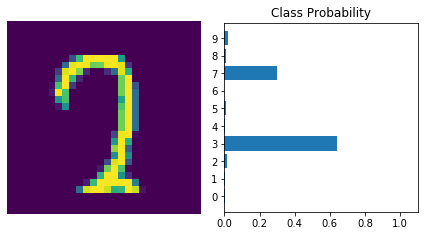

In [71]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.